In [2]:
%pip install --quiet numpy==1.26.4 opencv-python==4.9.0.80 scikit-image==0.25.2 scikit-learn==1.5.2 matplotlib==3.8.4

import os, glob, numpy as np, cv2, matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans

DATA_DIR  = r"C:\Datasets\sugarcane_dib_2024\Sugarcane_Leaf_Splits"
TEST_DIR  = os.path.join(DATA_DIR, "test")
IMG_SIZE  = 512

def load_rgb01(path, size=IMG_SIZE):
    bgr = cv2.imread(path)
    if bgr is None:
        raise FileNotFoundError(path)
    h, w = bgr.shape[:2]
    s = size / max(h, w)
    bgr = cv2.resize(bgr, (int(w*s), int(h*s)), interpolation=cv2.INTER_AREA)
    pad_h = size - bgr.shape[0]
    pad_w = size - bgr.shape[1]
    bgr = cv2.copyMakeBorder(bgr, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT_101)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return rgb.astype(np.float32) / 255.0



Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --quiet matplotlib-inline==0.1.7
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")
import matplotlib.pyplot as plt
print("backend:", matplotlib.get_backend())


Note: you may need to restart the kernel to use updated packages.
backend: module://matplotlib_inline.backend_inline


In [4]:
class CrazyImageAIPreprocessor:
    def __init__(self, config=None):
        self.config = config or {}
        print("🔥 INITIALIZING INSANE IMAGE AI PIPELINE!")

    def enhance_with_clahe(self, image):
        lab = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_RGB2LAB)
        L,a,b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        L = clahe.apply(L)
        lab = cv2.merge([L,a,b])
        enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        return enhanced.astype(np.float32)/255.0

    def ai_powered_denoising(self, image):
        img_uint8 = (image*255).astype(np.uint8)
        den = cv2.fastNlMeansDenoisingColored(img_uint8, None, 10, 10, 7, 21)
        bil = cv2.bilateralFilter(den, 9, 75, 75)
        return bil.astype(np.float32)/255.0

    def segment_leaf_regions(self, image):
        hsv = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_RGB2HSV)
        lower_green1, upper_green1 = np.array([35,40,40]), np.array([85,255,255])
        lower_green2, upper_green2 = np.array([25,40,40]), np.array([35,255,255])
        mask1 = cv2.inRange(hsv, lower_green1, upper_green1)
        mask2 = cv2.inRange(hsv, lower_green2, upper_green2)
        plant_mask = cv2.bitwise_or(mask1, mask2)
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
        plant_mask = cv2.morphologyEx(plant_mask, cv2.MORPH_CLOSE, k)
        plant_mask = cv2.morphologyEx(plant_mask, cv2.MORPH_OPEN,  k)
        plant_mask_3d = np.stack([plant_mask]*3, axis=-1)/255.0
        segmented = image * plant_mask_3d
        return segmented, (plant_mask.astype(np.float32)/255.0)

    def texture_analysis_features(self, image):
        gray = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        lbp = local_binary_pattern(gray, P=24, R=8, method='uniform')
        if lbp.max() > lbp.min():
            lbp_norm = (lbp - lbp.min())/(lbp.max()-lbp.min())
        else:
            lbp_norm = np.zeros_like(lbp, dtype=np.float32)
        tex = image.copy()
        tex[:,:,1] = np.clip(tex[:,:,1]*(1.0 + 0.2*lbp_norm), 0, 1)
        return tex

    def disease_hotspot_detection(self, image):
        lab = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_RGB2LAB)
        h,w = lab.shape[:2]
        lab_reshaped = lab.reshape(-1,3).astype(np.float32)
    
        kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
        labels = kmeans.fit_predict(lab_reshaped).reshape(h,w)
        centers = kmeans.cluster_centers_  # shape (4,3): L,a,b
    
        # Heuristic: darker (low L) or reddish (high a) or bluish (low b)
        disease_clusters = []
        for i in range(centers.shape[0]):
            Lc, ac, bc = centers[i]
            if (Lc < 120) or (ac > 135) or (bc < 120):
                disease_clusters.append(i)
    
        disease_map = np.zeros((h,w), dtype=np.float32)
        for cid in disease_clusters:
            disease_map[labels==cid] = 1.0
    
        disease_map = cv2.GaussianBlur(disease_map, (7,7), 0)
    
        enhanced = image.copy()
        enhanced[:,:,0] = np.clip(enhanced[:,:,0] + 0.2*disease_map, 0, 1)  # more red
        enhanced[:,:,1] = np.clip(enhanced[:,:,1] - 0.1*disease_map, 0, 1)  # less green
        return enhanced, disease_map


    def edge_enhancement_ai(self, image):
        gray = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        edges_canny = cv2.Canny(gray, 50, 150).astype(np.float32)/255.0
        sx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
        sy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
        mag = np.sqrt(sx*sx + sy*sy)
        mag = (mag / (mag.max()+1e-6)).astype(np.float32)
        edges = np.clip(0.5*edges_canny + 0.5*mag, 0, 1)
        edges_3d = np.stack([edges]*3, axis=-1)
        return np.clip(image + 0.3*edges_3d, 0, 1)

    def super_resolution_upscale(self, image):
        h,w = image.shape[:2]
        up = cv2.resize(image, (w*2, h*2), interpolation=cv2.INTER_CUBIC)
        k = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]], dtype=np.float32)
        out = np.zeros_like(up)
        for i in range(3):
            out[:,:,i] = cv2.filter2D(up[:,:,i], -1, k)
        final = cv2.resize(out, (w, h), interpolation=cv2.INTER_LANCZOS4)
        return np.clip(final, 0, 1)

    def color_space_analysis(self, image):
        hsv = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
        hsv[:,:,1] = np.clip(hsv[:,:,1]*1.2, 0, 255)
        v_mean = float(hsv[:,:,2].mean())
        if v_mean < 100:
            hsv[:,:,2] = np.clip(hsv[:,:,2]*1.3, 0, 255)
        elif v_mean > 200:
            hsv[:,:,2] = np.clip(hsv[:,:,2]*0.9, 0, 255)
        out = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB).astype(np.float32)/255.0
        return out

    def apply_crazy_pipeline(self, image):
        print("🔥 Processing with INSANE AI pipeline...")
        x = self.super_resolution_upscale(image)
        x = self.ai_powered_denoising(x)
        x = self.enhance_with_clahe(x)
        x, leaf_mask = self.segment_leaf_regions(x)
        x = self.texture_analysis_features(x)
        x, disease_map = self.disease_hotspot_detection(x)
        x = self.edge_enhancement_ai(x)
        x = self.color_space_analysis(x)
        return x, leaf_mask, disease_map


🔥 INITIALIZING INSANE IMAGE AI PIPELINE!
🔥 Processing with INSANE AI pipeline...


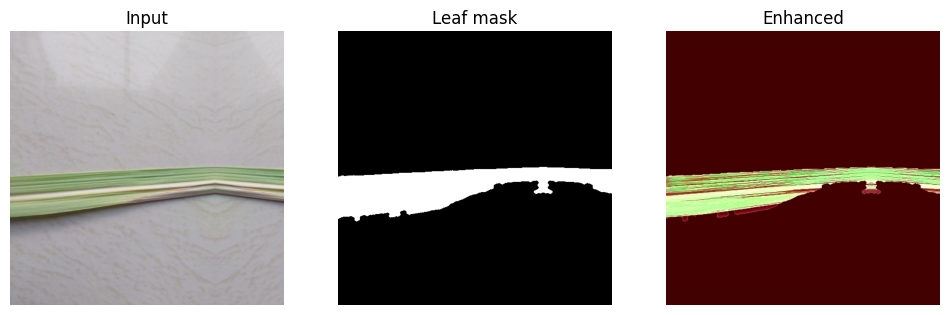

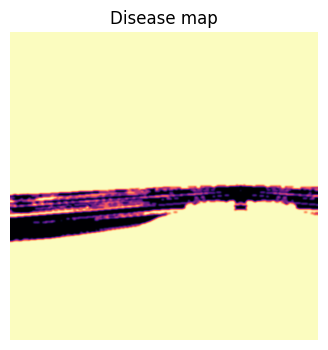

In [5]:
proc = CrazyImageAIPreprocessor()

# pick a sample from any class
classes = sorted([d for d in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, d))])
any_class = classes[0]                     # choose the first class (or random.choice(classes))
paths = glob.glob(os.path.join(TEST_DIR, any_class, "*"))
assert len(paths)>0, "No images found"
sample_path = paths[0]                     # choose the first image
img = load_rgb01(sample_path, IMG_SIZE)

enh, mask, dmap = proc.apply_crazy_pipeline(img)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.imshow(img);  plt.title("Input"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(mask, cmap='gray'); plt.title("Leaf mask"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(enh);  plt.title("Enhanced"); plt.axis('off')
plt.show()

plt.figure(figsize=(5,4)); plt.imshow(dmap, cmap='magma'); plt.title("Disease map"); plt.axis('off'); plt.show()
